# **Time Series Analysis & Geo Maps**


*   **Data Source:**

Table1: Temperature and wind speed data from the BDL observation station for the years 2011 to 2021.

Table2: Environmental data from IEM spanning a duration of 4 days, encompassing over 5000 stations.

*  **Objectives:**
    
1.   Handling missing values on time series data
2.   Feature engineering on date feature
3.   Exploring Data Analysis
4.   Geo Maps










In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 📖 Import Table

In [ ]:
# https://drive.google.com/file/d/1yb3ICxF8V0tls4XkGs_4hcPLM2Q-7pvj/view?usp=drive_link
!gdown 1yb3ICxF8V0tls4XkGs_4hcPLM2Q-7pvj

Downloading...
From: https://drive.google.com/uc?id=1yb3ICxF8V0tls4XkGs_4hcPLM2Q-7pvj
To: /content/BDL_celsius_data.csv
100% 2.86M/2.86M [00:00<00:00, 93.8MB/s]


In [ ]:
df = pd.read_csv('/content/BDL_celsius_data.csv')
df.shape

(95840, 4)

In [ ]:
df.head()

,station,valid,tmpc,sped
0,BDL,1/1/2011 0:51,1.1,NaN
1,BDL,1/1/2011 1:51,1.1,NaN
2,BDL,1/1/2011 2:51,-0.6,NaN
3,BDL,1/1/2011 3:51,-1.1,NaN
4,BDL,1/1/2011 4:51,-1.7,NaN


In [ ]:
df.isnull().sum() # check null values

station      0
valid        0
tmpc        75
sped       841
dtype: int64

## Correlation Analysis


Let's compare the differences in output resulting from different methods of handling missing values.

### Method1 - drop all missing value

In [ ]:
df_clean = df.dropna() # drop all null values

In [ ]:
correlation_drop = df_clean['tmpc'].corr(df_clean['sped']) # calculate the correlationship between wind speed and temperature

In [ ]:
print(f'Correlation between temperature and wind speed:',correlation_drop)

Correlation between temperature and wind speed: 0.008395615263385874


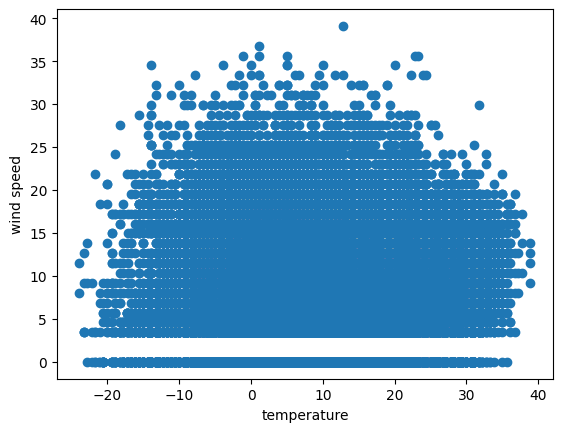

In [ ]:
# scatter plot
plt.scatter(df_clean['tmpc'],df_clean['sped'])
plt.xlabel('temperature')
plt.ylabel('wind speed')
plt.show()

***No linear relationship. The correlation between temperature and wind speed is very weak or almost negligible.***

### Method2 - forward fill

Fill missing values with the data from the previous row.

In [ ]:
df_ffill = df.fillna(method = 'ffill')

In [ ]:
correlation_ffill = df_ffill['tmpc'].corr(df_ffill['sped'])

In [ ]:
print(f'Correlation between temperature and wind speed:',correlation_ffill)

Correlation between temperature and wind speed: 0.010518280845378767


In [ ]:
print(f'difference - ', round((correlation_ffill - correlation_drop)*100/correlation_drop,3),'%' )

difference -  25.283 %


### 🦾 Method3 - backward fill

Fill missing values with the data from the next row.

In [ ]:
# method = 'bfill'

## Explore Null Values

Let's return to original 'df' and focus on temperature.

In [ ]:
# set date as index
df['valid'] = pd.to_datetime(df['valid']) # data type
df.set_index('valid', inplace=True)

In [ ]:
# drop 'sped' column
df = df[['station', 'tmpc']]

In [ ]:
df.head()

,station,tmpc
valid,,
2011-01-01 00:51:00,BDL,1.1
2011-01-01 01:51:00,BDL,1.1
2011-01-01 02:51:00,BDL,-0.6
2011-01-01 03:51:00,BDL,-1.1
2011-01-01 04:51:00,BDL,-1.7


### check missing values (daily)

In [ ]:
# Create boolean mask to identify rows with NaN values
mask = df.isna().any(axis=1)

# Resample filtered DataFrame at daily frequency and count null values for each day
days_with_nulls = df[mask].resample('D').apply(lambda x: x.count())['station'].rename("Nulls") # 'H', 'D', 'W', 'M', 'Q', 'Y'

# Select rows with 'Nulls' > 0
days_with_nulls = days_with_nulls[days_with_nulls > 0].reset_index()

days_with_nulls

,valid,Nulls
0,2011-10-29,7
1,2011-10-30,24
2,2011-10-31,24
3,2011-11-01,14
4,2011-11-09,1
5,2012-02-10,1
6,2012-02-15,1
7,2014-09-17,1
8,2017-01-08,1
9,2018-09-11,1


### filling missing values


*   If nulls >= threshold,replace the missing values with the temperature of the corresponding hour from the previous day.
*   Others, use forward filling



In [ ]:
def filling_missing_value(df, null_threshold):
  # generate daily missing value table
  mask = df.isna().any(axis=1)
  days_with_nulls = df[mask].resample('D').apply(lambda x: x.count())['station'].rename("Nulls")
  days_with_nulls = days_with_nulls[days_with_nulls > 0].reset_index()

  # extract dates that have missing values greater than null_threshold
  date_null = days_with_nulls[days_with_nulls['Nulls']>=null_threshold]['valid']
  df_null = df[df.index.isin(date_null)]
  missing_values = df_null['tmpc'].isnull() # identify missing value records

  for index, row in df_null[missing_values].iterrows(): # Replace missing values with temperature from corresponding hour of previous day
    previous_date = index - pd.Timedelta(days=1)
    previous_temperature = df.loc[(df.index.date == previous_date.date()) & (df.index.hour == index.hour)]['tmpc']
    if not previous_temperature.empty:  # Check if previous temperature is available
        df_null.at[index, 'tmpc'] = previous_temperature

  df.update(df_null)

  df.fillna(method='ffill', inplace=True) # less than thresholds

In [ ]:
filling_missing_value(df,10)

In [ ]:
df.isnull().sum()

station    0
tmpc       0
dtype: int64

In [ ]:
df.shape

(95840, 2)

## Feature Engineering

In data mining, the process of creating new features or improving existing features by transforming, combining and extracting features from original data to improve model performance.


*   Year/Quarter/Month/Day
*   Hour
*   Season
*   Day(Night)



In [ ]:
def make_time_features(df):

  date = (df.index.month*100 + df.index.day-320)%1300  #used to define season

  return (
      df.assign(
          Year = df.index.year,
          Month = df.index.month,
          Day = df.index.day,
          Hour = df.index.hour,
          Quarter = df.index.quarter,
          Season = (pd.cut(date,[0,300,602,900,1300], #Spring: Mar 21-Jun 20; Summer: Jun 21- Sep 22; Autumn: Sep 23-Dec 20; Winter: Dec 21-Mar 20
                           labels = ['spring', 'summer', 'autumn', 'winter'])).fillna('winter'), # fill in winter for 3/20 which are Nans
          Period = pd.cut(df.index.hour,
                      bins=[0, 5, 11, 17, 23],
                      labels=['Dawn', 'Morning', 'Afternoon', 'Night']).fillna('Dawn')
      )
  )

dff = make_time_features(df)
dff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95840 entries, 2011-01-01 00:51:00 to 2021-12-30 23:51:00
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   station  95840 non-null  object  
 1   tmpc     95840 non-null  float64 
 2   Year     95840 non-null  int32   
 3   Month    95840 non-null  int32   
 4   Day      95840 non-null  int32   
 5   Hour     95840 non-null  int32   
 6   Quarter  95840 non-null  int32   
 7   Season   95840 non-null  category
 8   Period   95840 non-null  category
dtypes: category(2), float64(1), int32(5), object(1)
memory usage: 4.2+ MB


In [ ]:
dff.head()

,station,tmpc,Year,Month,Day,Hour,Quarter,Season,Period
valid,,,,,,,,,
2011-01-01 00:51:00,BDL,1.1,2011,1,1,0,1,winter,Dawn
2011-01-01 01:51:00,BDL,1.1,2011,1,1,1,1,winter,Dawn
2011-01-01 02:51:00,BDL,-0.6,2011,1,1,2,1,winter,Dawn
2011-01-01 03:51:00,BDL,-1.1,2011,1,1,3,1,winter,Dawn
2011-01-01 04:51:00,BDL,-1.7,2011,1,1,4,1,winter,Dawn


# 📖 EDA

*   Story1: Do we have a trend of warmer winters?
*   Story2: Hot Hours Analysis



## Warm Winter?

### Monthly Average

In [ ]:
df_winter = dff[dff['Season']=='winter']
winter_avg_temp = df_winter.groupby(['Year','Month'])['tmpc'].mean().unstack() # monthly avg temp
# unstack() is to rearrange the data stack form of a multilevel index into a new dataframe, where one (or more) index levels are converted into columns

winter_avg_temp = winter_avg_temp[[12, 1, 2, 3]] # adjust columns order

december_row = winter_avg_temp.loc[:,12]
winter_avg_temp.loc[:,12] = np.roll(december_row, shift=1) # The data for December was shifted down by one row, so the data for "2012 Dec" actually corresponds to the value for December 2021.
winter_avg_temp.iloc[0,0] = np.nan

In [ ]:
winter_avg_temp.columns=['Dec', 'Jan', 'Feb', 'Mar']

In [ ]:
winter_avg_temp

,Dec,Jan,Feb,Mar
Year,,,,
2011,NaN,-4.673750,-2.538750,3.255708
2012,2.618702,-0.150941,2.132565,6.952092
2013,-0.299242,-1.394482,-1.321076,2.100210
2014,1.044697,-4.226245,-3.799254,-1.446862
2015,2.882197,-4.505518,-7.943881,0.123480
2016,6.349621,-1.027322,-0.093247,5.936534
2017,1.539924,0.376761,1.516228,-0.311795
2018,-7.208859,-3.322436,2.076161,1.603486
2019,2.764091,-3.250135,-0.800641,0.994465


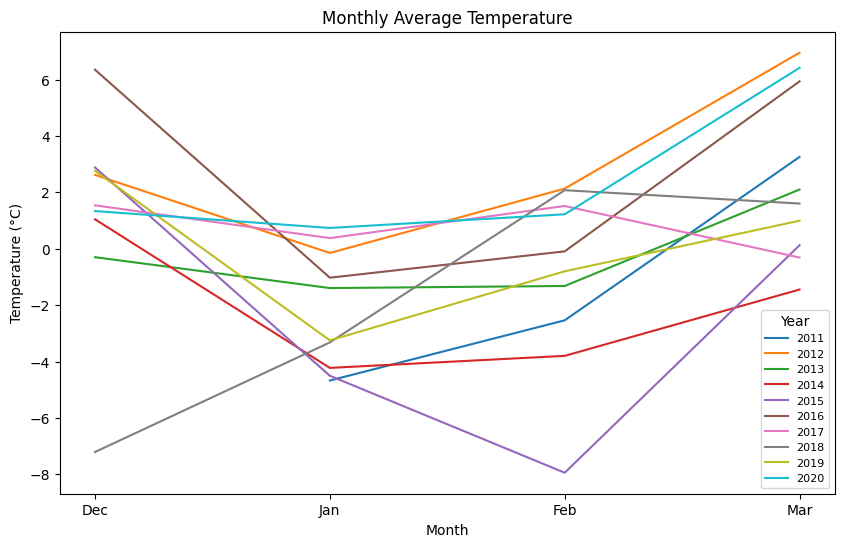

In [ ]:
plt.figure(figsize=(10, 6))
for year in range(2011, 2021):
    plt.plot(winter_avg_temp.loc[year].index, winter_avg_temp.loc[year].values, label=str(year))

plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(0, 4), ['Dec', 'Jan', 'Feb', 'Mar'])
plt.legend(title='Year', fontsize=8)
# plt.grid(True)
plt.show()

### Moving Average (7 days)

Moving Average analysis is a common time series analysis method used to smooth data and identify long-term trends. It reduces noise and fluctuations in the data by calculating the average of the data points within a given time window.

In [ ]:
moving_avg_data = dff.groupby(['Year','Month','Day'])['tmpc'].mean().reset_index()

# Combine year, month, and day into a single date column
moving_avg_data['Date'] = pd.to_datetime(moving_avg_data[['Year', 'Month', 'Day']])

# Calculate 7-day moving average
moving_avg_data['7-Day Moving Avg'] = moving_avg_data.groupby('Year')['tmpc'].rolling(window=7, min_periods=7).mean().values

moving_avg_data = moving_avg_data.dropna().reset_index(drop=True)


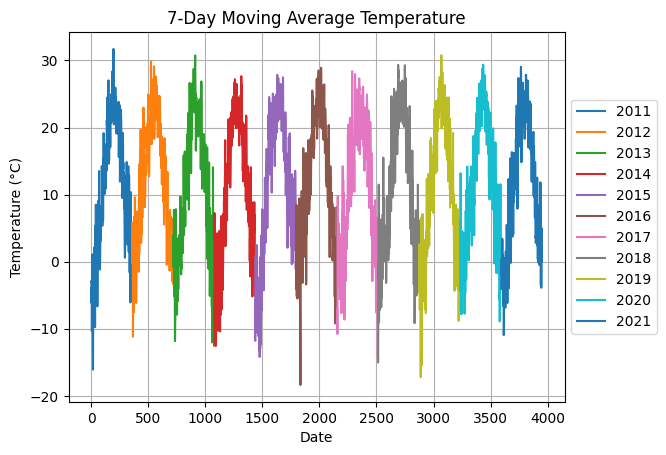

In [ ]:
# Plotting
years = moving_avg_data['Year'].unique()
for year in years:
    year_data = moving_avg_data[moving_avg_data['Year'] == year]
    plt.plot(year_data.index, year_data['tmpc'], label=str(year))

plt.title('7-Day Moving Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

### Hot Hours

In [ ]:
# Define tmpc >= 25℃ as hot hour, create a new column as flag
dff['hotflag'] = np.where(dff['tmpc']>=25,1,0)

In [ ]:
dff['hotflag'].value_counts()

hotflag
0    85747
1    10093
Name: count, dtype: int64

In [ ]:
# calculate hot hours per year
df_hot_hour = dff[dff['tmpc']>=25].groupby(['Year'])['hotflag'].sum().reset_index()
df_hot_hour.columns = ['Year','hours'] # rename columns

In [ ]:
df_hot_hour

,Year,hours
0,2011,873
1,2012,965
2,2013,841
3,2014,798
4,2015,975
5,2016,1094
6,2017,820
7,2018,1033
8,2019,893
9,2020,1000


In [ ]:
fig = px.bar(df_hot_hour, x='Year', y='hours', text='hours', color_discrete_sequence=['skyblue'])
fig.update_traces(textposition='outside')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Hours')
fig.update_layout(title_text='Hot Hours per year')
fig.show()

***During this decade-long period, there isn't a clear global warming trend evident in CT.***

## 🦾 on your own

*   explor warm summer
*   moving average (30 days)
*   pie plot (period vs hot hours)





In [ ]:
df_summer = dff[dff['Season']=='summer']
summer_avg_temp = df_summer.groupby(['Year','Month'])['tmpc'].mean().unstack()
summer_avg_temp = summer_avg_temp[[6, 7, 8, 9]]
summer_avg_temp.columns=['Jun', 'Jul', 'Aug', 'Sep']
summer_avg_temp

,Jun,Jul,Aug,Sep
Year,,,,
2011,20.841333,24.484234,22.188690,18.820990
2012,23.736667,24.341131,23.229825,19.128598
2013,24.478750,25.264151,21.373270,18.238258
2014,22.364167,23.421419,21.283737,18.835795
2015,20.574370,23.215209,23.050000,21.275947
2016,22.400000,24.547568,24.201211,20.997727
2017,21.821297,22.482429,21.480095,19.059886
2018,21.344393,24.413911,24.044374,20.854299
2019,23.632542,25.443149,22.330809,17.945133


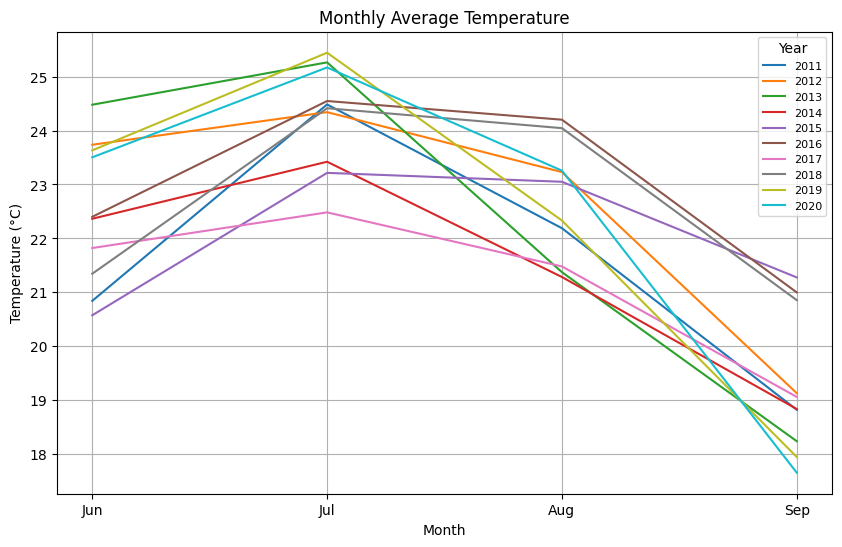

In [ ]:
plt.figure(figsize=(10, 6))
for year in range(2011, 2021):
    plt.plot(summer_avg_temp.loc[year].index, summer_avg_temp.loc[year].values, label=str(year))

plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(0, 4), ['Jun', 'Jul', 'Aug', 'Sep'])
plt.legend(title='Year', fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
df_hot_period = dff[dff['tmpc']>=25].groupby(['Year','Period'])['hotflag'].sum().reset_index()
df_hot_period.columns = ['Year','Period','hours'] # rename columns

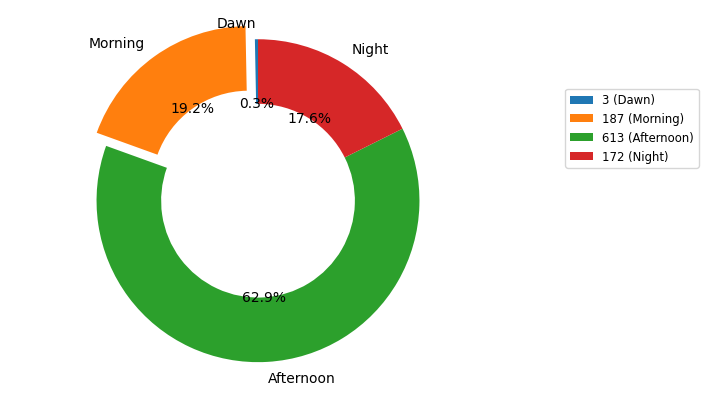

In [ ]:
sizes = df_hot_period[df_hot_period['Year']==2015]['hours']
labels = df_hot_period[df_hot_period['Year']==2015]['Period']
explode = (0, 0.1, 0, 0)
plt.figure()
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, wedgeprops=dict(width=0.4))

# Add text annotation for absolute values
absolute_values = [f'{size} ({label})' for size, label in zip(sizes, labels)]
plt.legend(wedges, absolute_values, loc="upper right", bbox_to_anchor=(1.4, 0.8), fontsize='small')

plt.axis('equal')
plt.show()

# Temp data with Geo info

In [ ]:
# data source: IEM ASOS download service
# https://drive.google.com/file/d/1X4vZCm0OGzIMvtpwqMB1il9HfvkP2p0f/view?usp=drive_link
!gdown 1X4vZCm0OGzIMvtpwqMB1il9HfvkP2p0f

Downloading...
From (original): https://drive.google.com/uc?id=1X4vZCm0OGzIMvtpwqMB1il9HfvkP2p0f
From (redirected): https://drive.google.com/uc?id=1X4vZCm0OGzIMvtpwqMB1il9HfvkP2p0f&confirm=t&uuid=e1bc76cf-d515-4797-9bb5-1729137ac844
To: /content/geo_df.csv
100% 372M/372M [00:05<00:00, 73.0MB/s]


In [ ]:
df_geo = pd.read_csv('/content/geo_df.csv')

In [ ]:
df_geo.shape

(1926049, 32)

In [ ]:
df_geo.head(3)

,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,OESK,2020-08-27 00:00,40.1000,29.7851,82.40,33.80,17.38,360.00,5.00,0.00,...,M,M,M,M,M,M,M,80.03,OESK 270000Z 36005KT CAVOK 28/01 Q1010,M
1,VIAR,2020-08-27 00:00,74.8667,31.6333,80.60,77.00,88.83,0.00,0.00,0.00,...,BR,M,M,M,M,M,M,87.59,VIAR 270000Z 00000KT 3000 BR SCT030 BKN090 27/...,M
2,VEBS,2020-08-27 00:00,85.8178,20.2444,77.00,77.00,100.00,170.00,8.00,0.00,...,-RA,M,M,M,M,M,M,77.00,VEBS 270000Z 17008KT 4000 -RA FEW012 BKN016 OV...,M


## data processing

In [ ]:
# extrct the first 5 features
df_geo = df_geo.iloc[:,0:5]

In [ ]:
df_geo.shape

(1926049, 5)

In [ ]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926049 entries, 0 to 1926048
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   station  object 
 1   valid    object 
 2   lon      float64
 3   lat      float64
 4   tmpf     object 
dtypes: float64(2), object(3)
memory usage: 73.5+ MB


In [ ]:
df_geo.isnull().sum()

station    0
valid      0
lon        0
lat        0
tmpf       0
dtype: int64

In [ ]:
# change data type
df_geo['valid'] = pd.to_datetime(df_geo['valid'])

# convert string 'M' into null value
df_geo['tmpf'] = np.where(df_geo['tmpf']=='M',np.nan, df_geo['tmpf'])
df_geo['tmpf'] = pd.to_numeric(df_geo['tmpf']) #change data type

In [ ]:
# add two more columns
df_geo['date'] = df_geo['valid'].dt.date
df_geo['hour'] = df_geo['valid'].dt.hour

In [ ]:
df_geo.isnull().sum()  # check null values

station          0
valid            0
lon              0
lat              0
tmpf       1128206
date             0
hour             0
dtype: int64

In [ ]:
tmp = df_geo.dropna() # drop null values

In [ ]:
# calculate the max temperature per station using a groupby
max_temp_index = tmp.groupby('station')['tmpf'].idxmax()
tmp2 = tmp.loc[max_temp_index]
tmp2

,station,valid,lon,lat,tmpf,date,hour
484970,00U,2020-08-25 00:10:00,-107.6604,45.7444,95.0,2020-08-25,0
889384,04V,2020-08-25 20:15:00,-106.1700,38.1000,86.0,2020-08-25,20
869535,04W,2020-08-25 19:15:00,-92.8952,46.0229,82.4,2020-08-25,19
946365,05U,2020-08-25 23:10:00,-116.0051,39.6042,95.0,2020-08-25,23
1865668,06C,2020-08-26 20:55:00,-88.1050,41.9913,92.3,2020-08-26,20
...,...,...,...,...,...,...,...
603009,ZYCC,2020-08-25 06:00:00,125.2167,43.9000,80.6,2020-08-25,6
1565737,ZYHB,2020-08-26 06:00:00,126.5800,46.0200,82.4,2020-08-26,6
590594,ZYTL,2020-08-25 05:30:00,121.6333,38.9000,82.4,2020-08-25,5
631080,ZYTX,2020-08-25 07:30:00,123.4000,41.8000,84.2,2020-08-25,7


## Geo Map

### max temperature

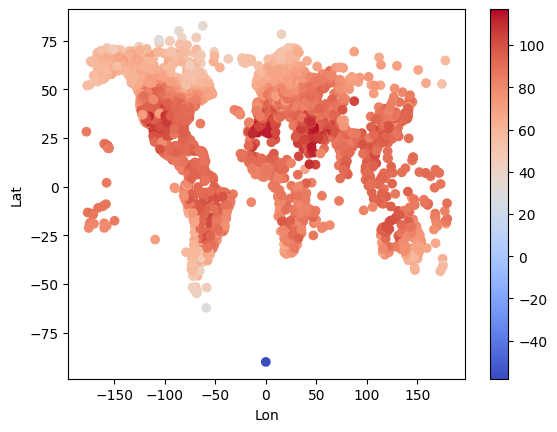

In [ ]:
example = plt.scatter(x=tmp2['lon'], y=tmp2['lat'], c = tmp2['tmpf'], cmap='coolwarm')
plt.colorbar(example)
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

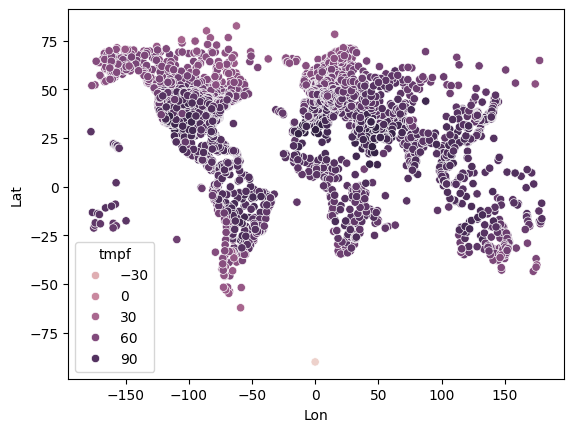

In [ ]:
sns.scatterplot(x=tmp2['lon'], y=tmp2['lat'], hue = tmp2['tmpf'])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

In [ ]:
!pip install geopandas

In [ ]:
# exclude 2 cold temperature outliers
tmp2 = tmp2[~(tmp2['tmpf']<0)]

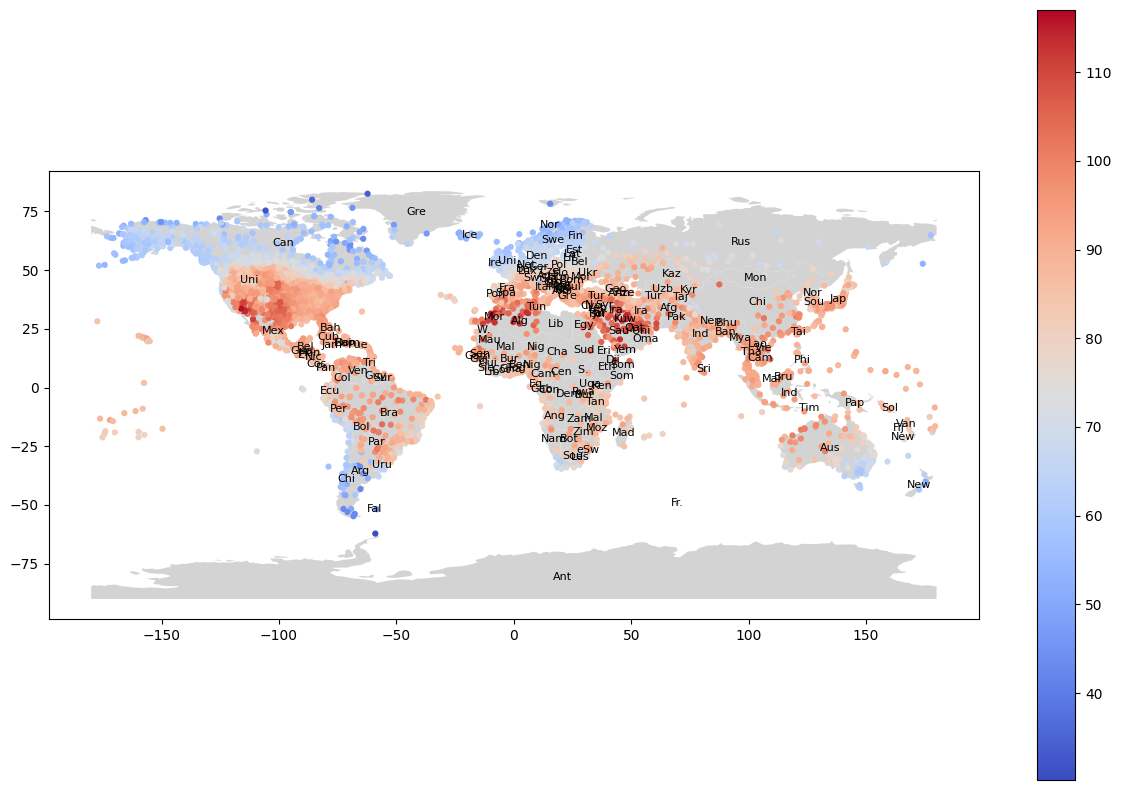

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# Point object represents a point on a plane, consisting of longitude and latitude coordinates
geometry = [Point(xy) for xy in zip(tmp2['lon'], tmp2['lat'])]

# Combine the raw data and the coordinates of the points into a GeoDataFrame
gdf = GeoDataFrame(tmp2, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#this is a simple map that goes with geopandas
gdf.plot(ax=world.plot(figsize=(15, 10),facecolor='lightgray'),
         column='tmpf',
         marker='o',
         markersize=12,
         cmap='coolwarm',
         legend=True)

# label the country abbr
for country, lon, lat in zip(world['name'], world['geometry'].centroid.x, world['geometry'].centroid.y):
    plt.text(lon, lat, country[:3], fontsize=8, ha='center', va='center', color='black')
plt.show()

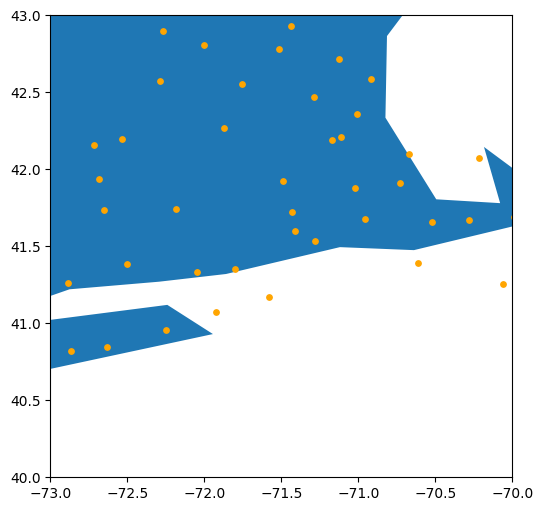

In [ ]:
# zoom in to a specific area (CT, MA)
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='orange', markersize=15)
plt.xlim([-73, -70])
plt.ylim([40, 43])
plt.show()

### 3 hourly data

In [ ]:
df_geo.head()

,station,valid,lon,lat,tmpf,date,hour
0,OESK,2020-08-27,40.1000,29.7851,82.4,2020-08-27,0
1,VIAR,2020-08-27,74.8667,31.6333,80.6,2020-08-27,0
2,VEBS,2020-08-27,85.8178,20.2444,77.0,2020-08-27,0
3,OERR,2020-08-27,41.1382,30.9066,84.2,2020-08-27,0
4,VIDP,2020-08-27,77.1167,28.5667,80.6,2020-08-27,0


In [ ]:
df_geo.shape

(1926049, 7)

In [ ]:
# convert data to hourly granularity
df_geo_hourly = df_geo.groupby(['station','lon','lat','date','hour'])['tmpf'].mean().reset_index()

In [ ]:
# retain station info with more than 75 rows
hourly_counts = df_geo_hourly['station'].value_counts()
stations_greater_75 = hourly_counts[hourly_counts>75].index.values
df_geo_final = df_geo_hourly[df_geo_hourly['station'].isin(stations_greater_75)]

In [ ]:
df_geo_final.shape

(414315, 6)

In [ ]:
df_geo_final.head()

,station,lon,lat,date,hour,tmpf
0,00U,-107.6604,45.7444,2020-08-25,0,93.5
1,00U,-107.6604,45.7444,2020-08-25,1,87.5
2,00U,-107.6604,45.7444,2020-08-25,2,83.3
3,00U,-107.6604,45.7444,2020-08-25,3,88.4
4,00U,-107.6604,45.7444,2020-08-25,4,84.8


In [ ]:
df_geo_final['station'].nunique()

4376

In [ ]:
# null value analysis
null_table = df_geo_final[df_geo_final['tmpf'].isna()]
null_station = null_table['station'].value_counts().reset_index()
null_station

,station,count
0,TOB,96
1,NOW,96
2,CWER,96
3,CWIG,96
4,CWPS,96
...,...,...
289,PAPO,1
290,HUEN,1
291,HUM,1
292,IGM,1


In [ ]:
# check stations with more than 30 missing values
ex_station = null_station[null_station['count']>30]['station']
df_geo_final = df_geo_final[~df_geo_final['station'].isin(ex_station)] # exclude them

In [ ]:
df_geo_final.shape

(409544, 6)

In [ ]:
# fill missing value
df_geo_filled = df_geo_final.groupby('station').apply(lambda group: group.fillna(method='ffill'))
df_geo_filled = df_geo_filled.reset_index(drop=True)
df_geo_filled = df_geo_filled.groupby('station').apply(lambda group: group.fillna(method='bfill'))

In [ ]:
# now you have a cleaned hourly dataset
df_geo_filled['date'] = pd.to_datetime(df_geo_filled['date'])
df_geo_filled['hour'] = pd.to_timedelta(df_geo_filled['hour'], unit='h')
df_geo_filled['valid'] = df_geo_filled['date'] + df_geo_filled['hour']
df_geo_filled.set_index('valid', inplace=True)
df_geo_filled.head()

,station,lon,lat,date,hour,tmpf
valid,,,,,,
2020-08-25 00:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 00:00:00,93.5
2020-08-25 01:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 01:00:00,87.5
2020-08-25 02:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 02:00:00,83.3
2020-08-25 03:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 03:00:00,88.4
2020-08-25 04:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 04:00:00,84.8


In [ ]:
# reshape to 3 hourly data with mean
df_resampled = df_geo_filled.groupby('station').resample('3H').mean()

In [ ]:
df_resampled.reset_index(inplace=True)
df_resampled.set_index('valid', inplace=True)

In [ ]:
df_resampled.head()

,station,lon,lat,date,hour,tmpf
valid,,,,,,
2020-08-25 00:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 01:00:00,88.1
2020-08-25 03:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 04:00:00,85.4
2020-08-25 06:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 07:00:00,74.3
2020-08-25 09:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 10:00:00,65.1
2020-08-25 12:00:00,00U,-107.6604,45.7444,2020-08-25,0 days 13:00:00,66.9


In [ ]:
# narrow to one day
df_resampled_0826 = df_resampled.loc['2020-08-26']

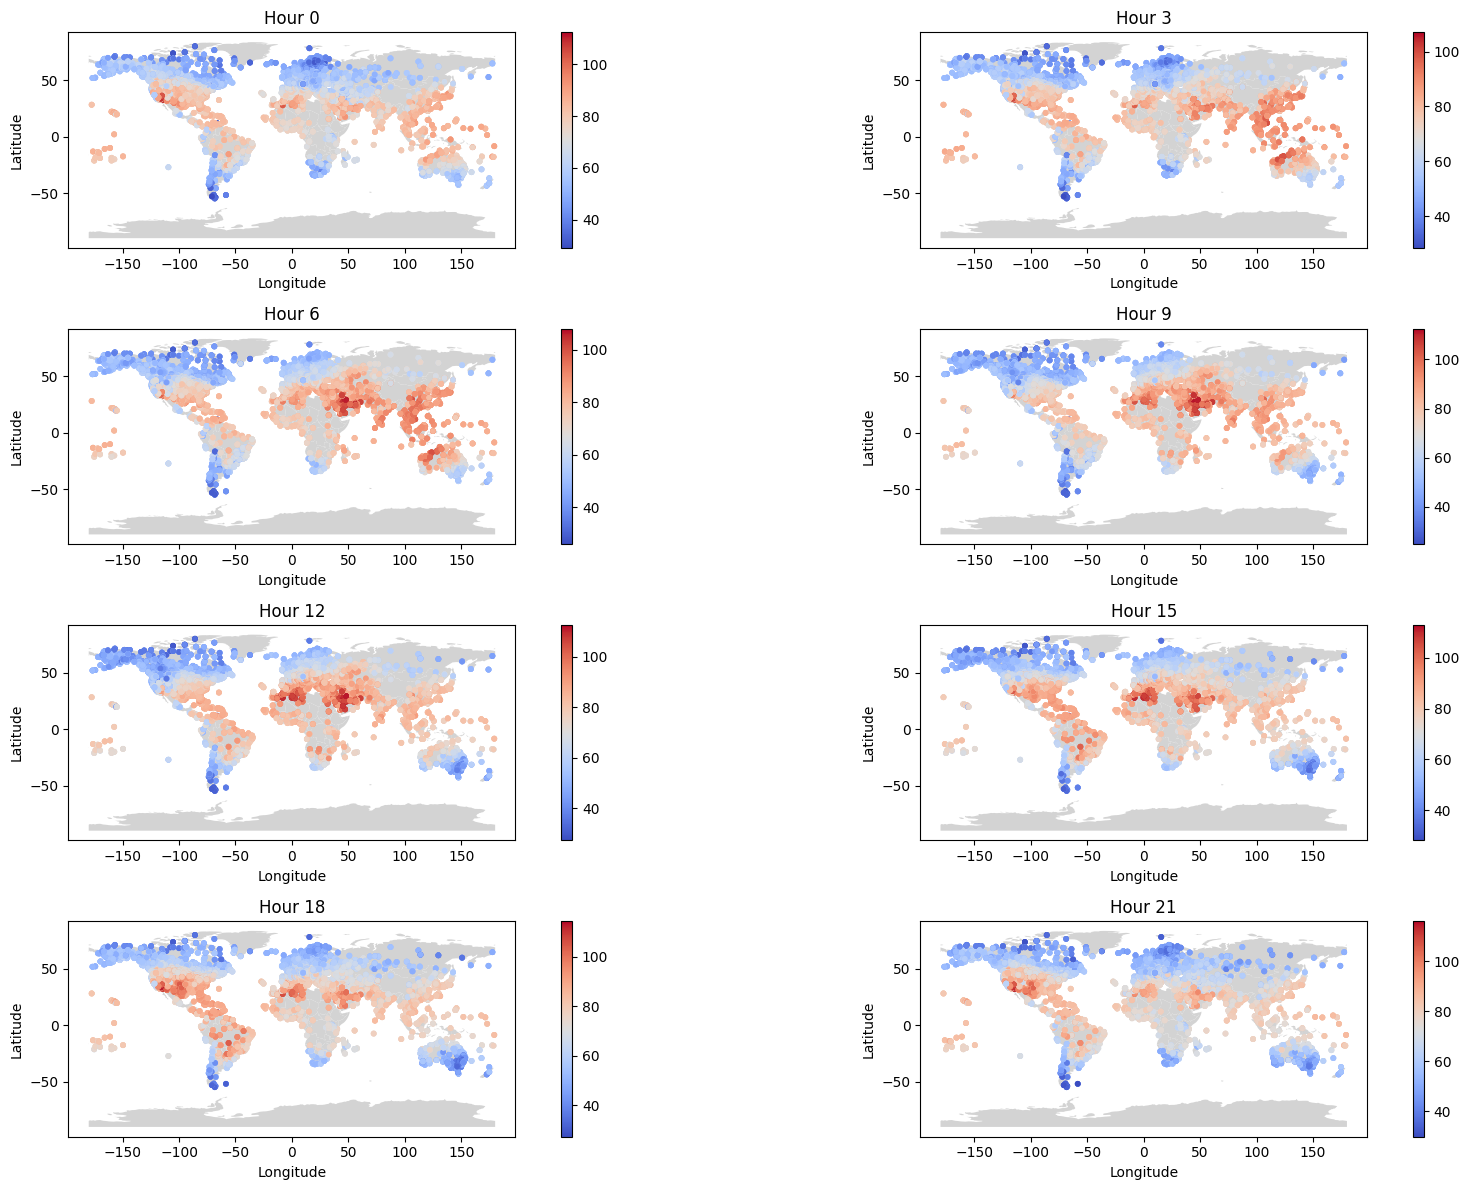

In [ ]:
# set layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 12))

# extract unique hour
unique_hours = df_resampled_0826.index.hour.unique()


for i, hour in enumerate(unique_hours):
    # calculate the current subplot's row index and column index
    row = i // 2 #  integer quotient
    col = i % 2 # remainder

    # extract subset
    data_hour = df_resampled[df_resampled.index.hour == hour]

    # create GeoDataFrame
    geometry2 = [Point(xy) for xy in zip(data_hour['lon'], data_hour['lat'])]
    gdf2 = GeoDataFrame(data_hour, geometry=geometry2)

    # world map and temperature
    world.plot(ax=axes[row, col], color='lightgray')
    gdf2.plot(ax=axes[row, col], column='tmpf', cmap='coolwarm', marker='o', markersize=10, legend=True)

    # setting
    axes[row, col].set_title(f'Hour {hour}')
    axes[row, col].set_xlabel('Longitude')
    axes[row, col].set_ylabel('Latitude')


plt.tight_layout()
plt.show()

### 🦾 on your own

In [ ]:
# try other days or time steps

In [ ]:
df_resampled2 = df_geo_filled.groupby('station').resample('4H').mean()

In [ ]:
df_resampled2.reset_index(inplace=True)
df_resampled2.set_index('valid', inplace=True)

In [ ]:
df_resampled_0827 = df_resampled2.loc['2020-08-27']

In [ ]:
df_resampled_0827

,station,lon,lat,date,hour,tmpf
valid,,,,,,
2020-08-27 00:00:00,00U,-107.6604,45.7444,2020-08-27,0 days 01:30:00,81.125
2020-08-27 04:00:00,00U,-107.6604,45.7444,2020-08-27,0 days 05:30:00,69.950
2020-08-27 08:00:00,00U,-107.6604,45.7444,2020-08-27,0 days 09:30:00,62.735
2020-08-27 12:00:00,00U,-107.6604,45.7444,2020-08-27,0 days 13:30:00,62.225
2020-08-27 16:00:00,00U,-107.6604,45.7444,2020-08-27,0 days 17:30:00,72.800
...,...,...,...,...,...,...
2020-08-27 04:00:00,ZZV,-81.8921,39.9445,2020-08-27,0 days 05:30:00,73.500
2020-08-27 08:00:00,ZZV,-81.8921,39.9445,2020-08-27,0 days 09:30:00,71.750
2020-08-27 12:00:00,ZZV,-81.8921,39.9445,2020-08-27,0 days 13:30:00,78.125


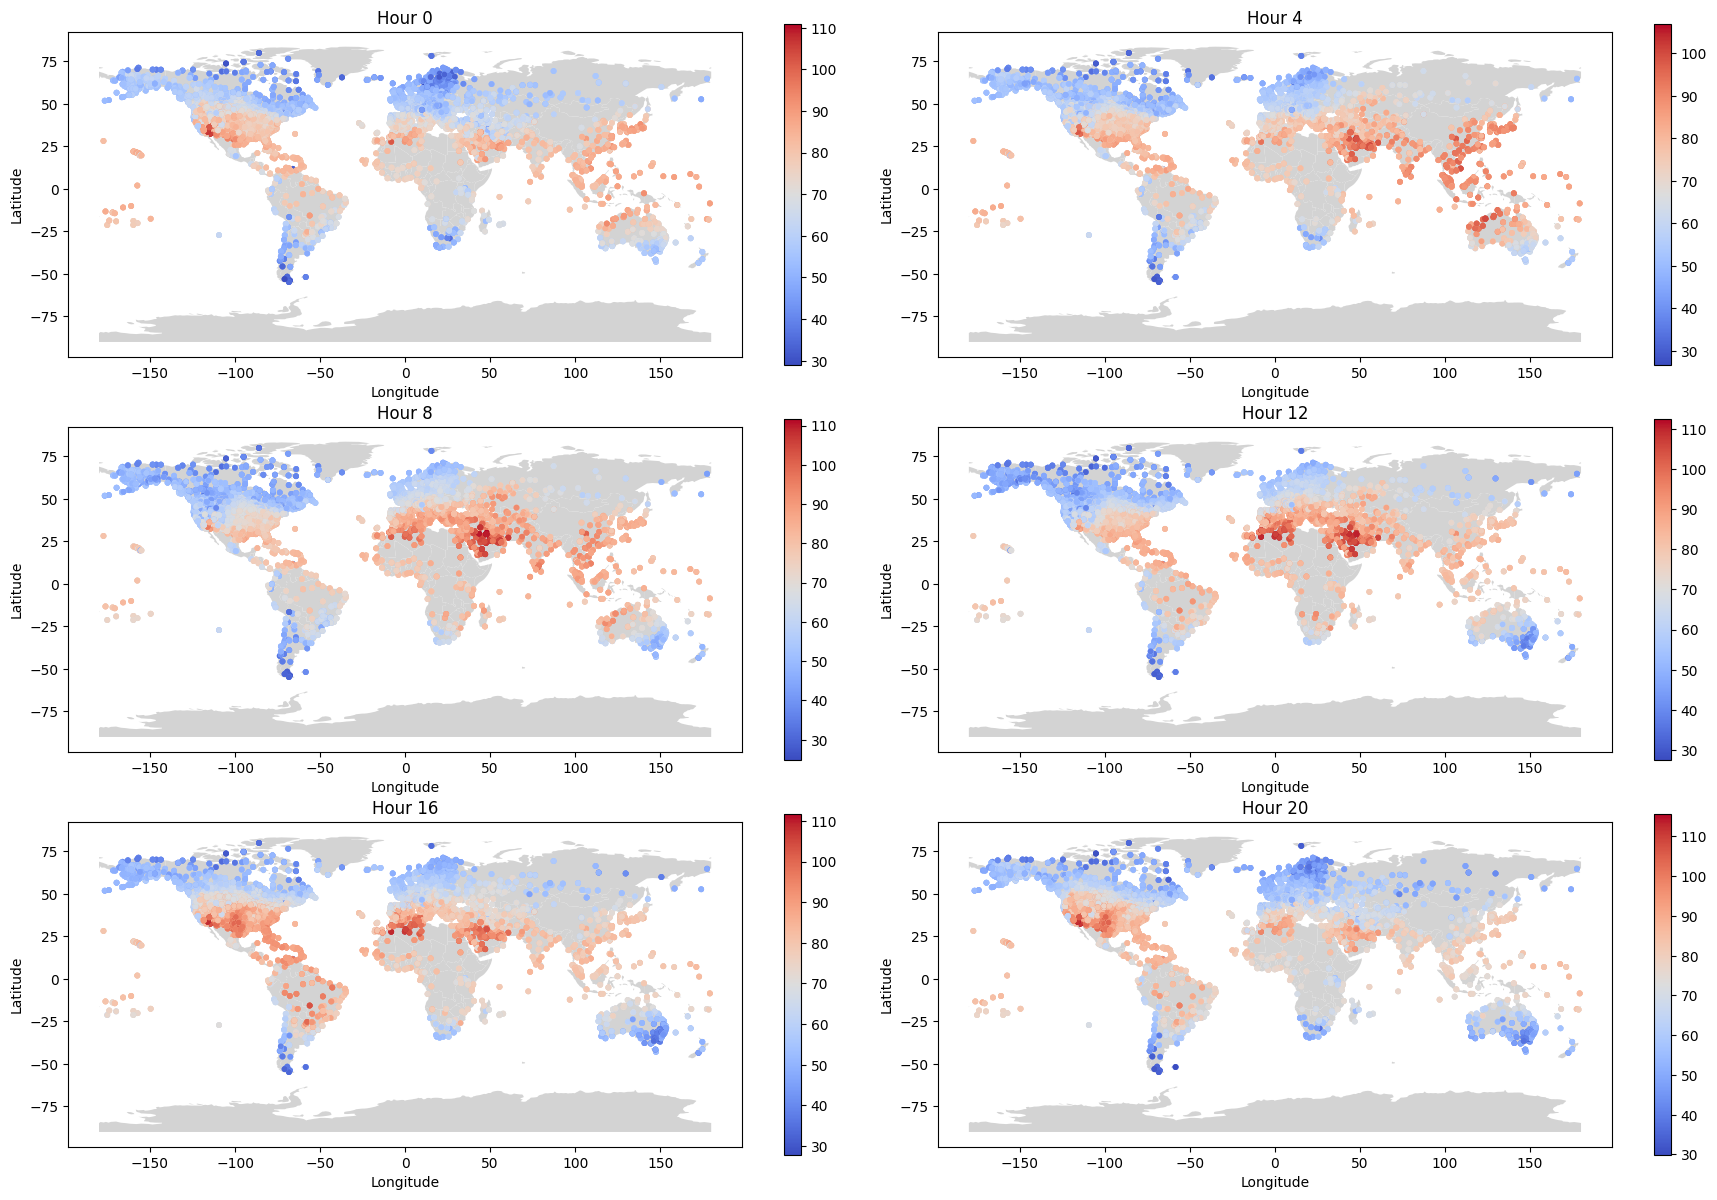

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

# extract unique hour
unique_hours = df_resampled_0827.index.hour.unique()

for i, hour in enumerate(unique_hours):
    # calculate the current subplot's row index and column index
    row = i // 2
    col = i % 2

    # extract subset
    data_hour = df_resampled2[df_resampled2.index.hour == hour]

    # create GeoDataFrame
    geometry2 = [Point(xy) for xy in zip(data_hour['lon'], data_hour['lat'])]
    gdf2 = GeoDataFrame(data_hour, geometry=geometry2)

    # world map and temperature
    world.plot(ax=axes[row, col], color='lightgray')
    gdf2.plot(ax=axes[row, col], column='tmpf', cmap='coolwarm', marker='o', markersize=10, legend=True)

    # setting
    axes[row, col].set_title(f'Hour {hour}')
    axes[row, col].set_xlabel('Longitude')
    axes[row, col].set_ylabel('Latitude')


plt.tight_layout()
plt.show()